In [1]:
!pip install git+https://github.com/salaniz/pycocoevalcap.git

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-9s0njz3c
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-9s0njz3c
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=b4cce8979638a92d2d54d5001b6a9120ede855e114768a7eea33473132f57535
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwk4uytp/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap


In [2]:
!pip list | grep pycocoevalcap

pycocoevalcap                      1.2


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.cider.cider import Cider

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Enable CuDNN benchmark for performance
torch.backends.cudnn.benchmark = True

In [6]:
caption_file="/kaggle/input/flickr8k/captions.txt"
image_dir="/kaggle/input/flickr8k/Images/"

In [7]:
# Load dataset
df = pd.read_csv(caption_file)
print("\nSample data:")
print(df.head())


Sample data:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [8]:
# Load spaCy English model for tokenization
spacy_en = spacy.load("en_core_web_sm")

In [9]:
# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return [token.text.lower() for token in spacy_en.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] = frequencies.get(word, 0) + 1
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.itos[idx] = word
                self.stoi[word] = idx
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [self.stoi.get(token, self.stoi["<unk>"]) for token in tokenized_text]

In [10]:
# Build vocabulary
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(df['caption'].tolist())

In [11]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # Resize to a larger size
    transforms.RandomCrop(224),             # Random crop to 224x224
    transforms.RandomHorizontalFlip(),      # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
# Validation and test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Dataset class
class FlickrDataset(Dataset):
    def __init__(self, df, vocab, transform, image_dir):
        self.df = df
        self.vocab = vocab
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.iloc[idx]['caption']
        img_id = self.df.iloc[idx]['image']
        image = Image.open(os.path.join(self.image_dir, img_id)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        numericalized_caption = [self.vocab.stoi["<start>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<end>"]]
        return image, torch.tensor(numericalized_caption)

In [14]:
# Split dataset
train_ids, test_ids = train_test_split(df['image'].unique(), test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

train_df = df[df['image'].isin(train_ids)]
val_df = df[df['image'].isin(val_ids)]
test_df = df[df['image'].isin(test_ids)]

In [15]:
# Datasets with appropriate transforms
train_dataset = FlickrDataset(train_df, vocab, train_transform, image_dir)
val_dataset = FlickrDataset(val_df, vocab, val_transform, image_dir)
test_dataset = FlickrDataset(test_df, vocab, val_transform, image_dir)

In [16]:
# Collate function for padding sequences
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    padded_captions = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]
    return images, padded_captions, lengths

In [17]:
# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=1, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [18]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # resnet = models.resnet50(pretrained=True)
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad_(False)

    def forward(self, images):
        # No need for torch.no_grad() since parameters are frozen
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.embed(features))
        return features

In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)  # Dropout added after embedding
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.num_layers = num_layers

    def forward(self, features, captions):
        """
        Parameters:
        - features: encoder output (batch_size, embed_size)
        - captions: target captions (batch_size, seq_len)
        
        Returns:
        - outputs: (batch_size, seq_len-1, vocab_size)
        """
        # Remove <end> token from inputs
        embeddings = self.embed(captions[:, :-1])   # (batch_size, seq_len-1, embed_size)
        embeddings = self.dropout(embeddings)  # Apply dropout to embeddings
        h0 = features.unsqueeze(0).repeat(self.num_layers, 1, 1)  # Initialize GRU hidden state
        # Forward pass through GRU
        outputs, _ = self.gru(embeddings, h0)
        # Convert to vocabulary space
        outputs = self.linear(outputs)   # (batch_size, seq_len-1, vocab_size)
        return outputs

In [20]:
# Initialize models
embed_size = 512
hidden_size = 512
vocab_size = len(vocab)
num_layers = 2
dropout = 0.5

In [21]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, dropout).to(device)

print(f"Encoder device: {next(encoder.parameters()).device}")
print(f"Decoder device: {next(decoder.parameters()).device}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


Encoder device: cuda:0
Decoder device: cuda:0


In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=1e-4)  # Lower learning rate for stability
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)  # Adjust LR on plateau

In [23]:
def beam_search(image, encoder, decoder, vocab, beam_width=3, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Encode the image
        features = encoder(image)  # Shape: (1, embed_size)

        # Initialize hidden state with num_layers
        initial_hidden = features.unsqueeze(0).repeat(decoder.num_layers, 1, 1)  # Shape: (num_layers, 1, hidden_size)

        # Start with <start> token
        initial_input = torch.tensor([vocab.stoi['<start>']]).to(image.device)  # Shape: (1,)
        candidates = [(initial_input, 0.0, initial_hidden)]

        for _ in range(max_length):
            new_candidates = []
            for seq, log_prob, hidden in candidates:
                if seq[-1] == vocab.stoi['<end>']:
                    new_candidates.append((seq, log_prob, hidden))
                    continue
                
                # Embed the last token
                embeddings = decoder.embed(seq[-1].unsqueeze(0))  # Shape: (1, embed_size)
                embeddings = embeddings.unsqueeze(1)  # Shape: (1, 1, embed_size)

                # Pass through GRU
                output, hidden = decoder.gru(embeddings, hidden)  # output: (1, 1, hidden_size), hidden: (num_layers, 1, hidden_size)
                
                # Process output
                output = decoder.linear(output.squeeze(1))  # Shape: (1, vocab_size)
                log_probs = torch.log_softmax(output, dim=1)
                top_log_probs, top_indices = log_probs.topk(beam_width, dim=1)
                
                # Generate new candidates
                for i in range(beam_width):
                    new_token = top_indices[0, i].unsqueeze(0)  # Shape: (1,)
                    new_seq = torch.cat([seq, new_token])  # Append token to sequence
                    new_log_prob = log_prob + top_log_probs[0, i].item()
                    new_candidates.append((new_seq, new_log_prob, hidden))
            
            # Keep top beam_width candidates
            candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        
        # Extract the best sequence
        best_seq = candidates[0][0]
        caption = [vocab.itos[idx.item()] for idx in best_seq if idx.item() not in [vocab.stoi['<start>'], vocab.stoi['<end>']]]
        return ' '.join(caption)

In [24]:
# Training loop with early stopping
train_losses = []
val_losses = []
val_bleu_scores = []
val_cider_scores = []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
epochs_no_improve = 0
num_epochs = 50  # Max epochs

for epoch in range(num_epochs):
    # Training phase
    encoder.train()
    decoder.train()
    total_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, captions, _ in train_pbar:
        images = images.to(device, non_blocking=True)
        captions = captions.to(device, non_blocking=True)
        optimizer.zero_grad()
        features = encoder(images)
        outputs = decoder(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_pbar.set_postfix({'loss': f'{total_loss/(train_pbar.n+1):.3f}'})

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase with BLEU and CIDEr
    encoder.eval()
    decoder.eval()
    val_loss = 0
    references = []
    hypotheses = []
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch_idx, (images, captions, _) in enumerate(val_pbar):
            images = images.to(device, non_blocking=True)
            captions = captions.to(device, non_blocking=True)
            features = encoder(images)
            outputs = decoder(features, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].contiguous().view(-1))
            val_loss += loss.item()

            # Generate captions using beam search
            for i in range(images.size(0)):
                image = images[i].unsqueeze(0)
                generated_caption = beam_search(image, encoder, decoder, vocab, beam_width=3)
                img_id = val_df.iloc[batch_idx * batch_size + i]['image']
                ref_captions = val_df[val_df['image'] == img_id]['caption'].tolist()
                references.append(ref_captions)
                hypotheses.append(generated_caption)

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    # Compute BLEU-4
    bleu_score = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    val_bleu_scores.append(bleu_score)

    # Compute CIDEr
    ref_dict = {i: references[i] for i in range(len(references))}
    hyp_dict = {i: [hypotheses[i]] for i in range(len(hypotheses))}
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(ref_dict, hyp_dict)
    val_cider_scores.append(cider_score)

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(encoder.state_dict(), 'best_encoder.pth')
        torch.save(decoder.state_dict(), 'best_decoder.pth')
        print(f"Model saved at epoch {epoch+1}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break
    
    # Print epoch summary
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Val Loss: {val_loss:.4f} | BLEU-4: {bleu_score:.4f} | CIDEr: {cider_score:.4f}')

Epoch 1/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 1

Epoch [1/50]
Train Loss: 4.5316
Val Loss: 3.7473 | BLEU-4: 0.4774 | CIDEr: 0.2250


Epoch 2/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 2

Epoch [2/50]
Train Loss: 3.5325
Val Loss: 3.3239 | BLEU-4: 0.6262 | CIDEr: 0.3522


Epoch 3/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 3

Epoch [3/50]
Train Loss: 3.2162
Val Loss: 3.1213 | BLEU-4: 0.6272 | CIDEr: 0.4061


Epoch 4/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 4

Epoch [4/50]
Train Loss: 3.0289
Val Loss: 3.0007 | BLEU-4: 0.6206 | CIDEr: 0.4177


Epoch 5/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 5

Epoch [5/50]
Train Loss: 2.8935
Val Loss: 2.9183 | BLEU-4: 0.6137 | CIDEr: 0.4356


Epoch 6/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 6

Epoch [6/50]
Train Loss: 2.7906
Val Loss: 2.8590 | BLEU-4: 0.6249 | CIDEr: 0.4531


Epoch 7/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 7

Epoch [7/50]
Train Loss: 2.7076
Val Loss: 2.8141 | BLEU-4: 0.6355 | CIDEr: 0.4629


Epoch 8/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 8

Epoch [8/50]
Train Loss: 2.6341
Val Loss: 2.7808 | BLEU-4: 0.6437 | CIDEr: 0.4803


Epoch 9/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 9

Epoch [9/50]
Train Loss: 2.5710
Val Loss: 2.7524 | BLEU-4: 0.6427 | CIDEr: 0.4794


Epoch 10/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 10

Epoch [10/50]
Train Loss: 2.5145
Val Loss: 2.7284 | BLEU-4: 0.6350 | CIDEr: 0.4701


Epoch 11/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 11

Epoch [11/50]
Train Loss: 2.4642
Val Loss: 2.7124 | BLEU-4: 0.6454 | CIDEr: 0.4772


Epoch 12/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 12

Epoch [12/50]
Train Loss: 2.4191
Val Loss: 2.7026 | BLEU-4: 0.6380 | CIDEr: 0.4745


Epoch 13/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 13

Epoch [13/50]
Train Loss: 2.3747
Val Loss: 2.6890 | BLEU-4: 0.6418 | CIDEr: 0.4787


Epoch 14/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 14

Epoch [14/50]
Train Loss: 2.3356
Val Loss: 2.6792 | BLEU-4: 0.6310 | CIDEr: 0.4812


Epoch 15/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 15

Epoch [15/50]
Train Loss: 2.2973
Val Loss: 2.6733 | BLEU-4: 0.6460 | CIDEr: 0.4938


Epoch 16/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 16

Epoch [16/50]
Train Loss: 2.2635
Val Loss: 2.6659 | BLEU-4: 0.6464 | CIDEr: 0.4831


Epoch 17/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 17

Epoch [17/50]
Train Loss: 2.2303
Val Loss: 2.6628 | BLEU-4: 0.6407 | CIDEr: 0.4822


Epoch 18/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 18

Epoch [18/50]
Train Loss: 2.1985
Val Loss: 2.6583 | BLEU-4: 0.6487 | CIDEr: 0.4986


Epoch 19/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 19

Epoch [19/50]
Train Loss: 2.1702
Val Loss: 2.6557 | BLEU-4: 0.6436 | CIDEr: 0.5005


Epoch 20/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch [20/50]
Train Loss: 2.1419
Val Loss: 2.6567 | BLEU-4: 0.6495 | CIDEr: 0.5044


Epoch 21/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 21

Epoch [21/50]
Train Loss: 2.1158
Val Loss: 2.6527 | BLEU-4: 0.6463 | CIDEr: 0.4907


Epoch 22/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 22

Epoch [22/50]
Train Loss: 2.0907
Val Loss: 2.6520 | BLEU-4: 0.6450 | CIDEr: 0.4959


Epoch 23/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]

Model saved at epoch 23

Epoch [23/50]
Train Loss: 2.0658
Val Loss: 2.6514 | BLEU-4: 0.6443 | CIDEr: 0.4907


Epoch 24/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch [24/50]
Train Loss: 2.0436
Val Loss: 2.6560 | BLEU-4: 0.6393 | CIDEr: 0.4890


Epoch 25/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch [25/50]
Train Loss: 2.0214
Val Loss: 2.6621 | BLEU-4: 0.6451 | CIDEr: 0.4920


Epoch 26/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch [26/50]
Train Loss: 1.9999
Val Loss: 2.6633 | BLEU-4: 0.6447 | CIDEr: 0.4893


Epoch 27/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch [27/50]
Train Loss: 1.9802
Val Loss: 2.6688 | BLEU-4: 0.6413 | CIDEr: 0.4950


Epoch 28/50 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/64 [00:00<?, ?it/s]


Early stopping at epoch 28


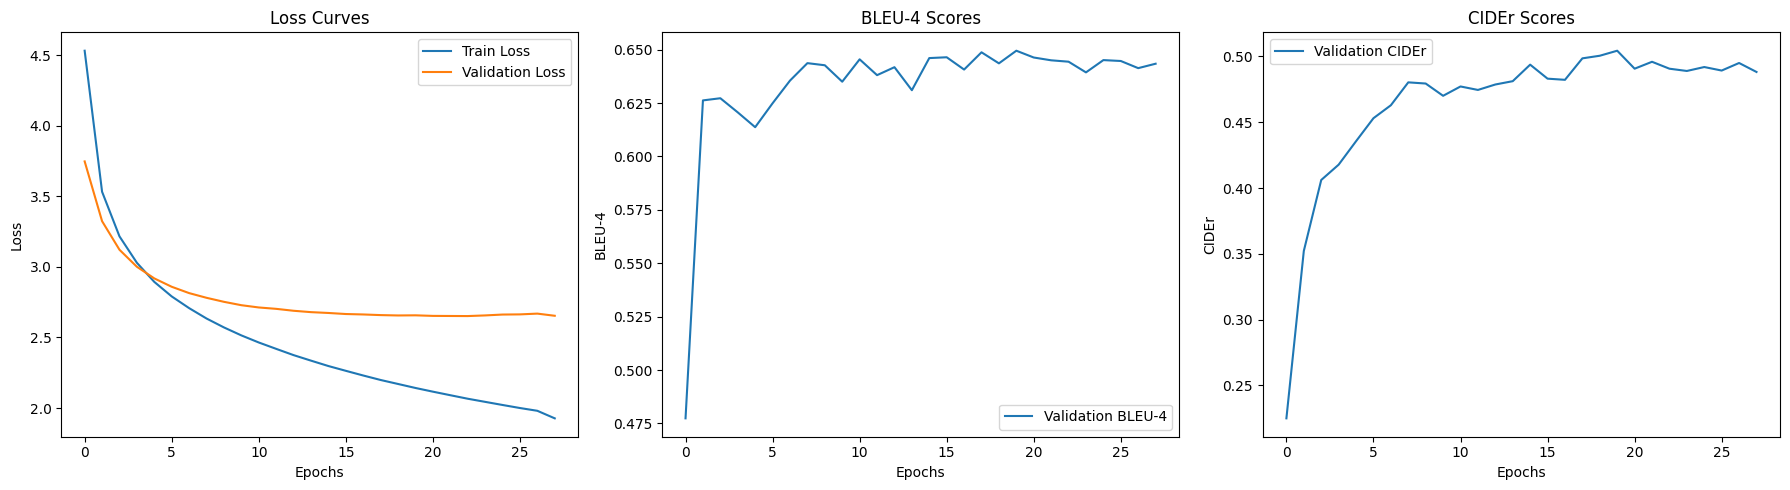

In [25]:
# Plotting epoch-wise metrics
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_bleu_scores, label='Validation BLEU-4')
plt.title('BLEU-4 Scores')
plt.xlabel('Epochs')
plt.ylabel('BLEU-4')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_cider_scores, label='Validation CIDEr')
plt.title('CIDEr Scores')
plt.xlabel('Epochs')
plt.ylabel('CIDEr')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
def generate_caption(image_path, encoder, decoder, vocab, transform, beam_width=3, max_length=20):
    """
    Generate a caption for an image using beam search.
    
    Args:
        image_path (str): Path to the image file.
        encoder (nn.Module): Trained encoder model.
        decoder (nn.Module): Trained decoder model.
        vocab (Vocabulary): Vocabulary object with word-to-index mapping.
        transform (torchvision.transforms): Image preprocessing transformations.
        beam_width (int): Number of beams for beam search (default: 3).
        max_length (int): Maximum length of the generated caption (default: 20).
    
    Returns:
        str: Generated caption.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Generate caption using beam search
    caption = beam_search(image, encoder, decoder, vocab, beam_width=beam_width, max_length=max_length)
    return caption

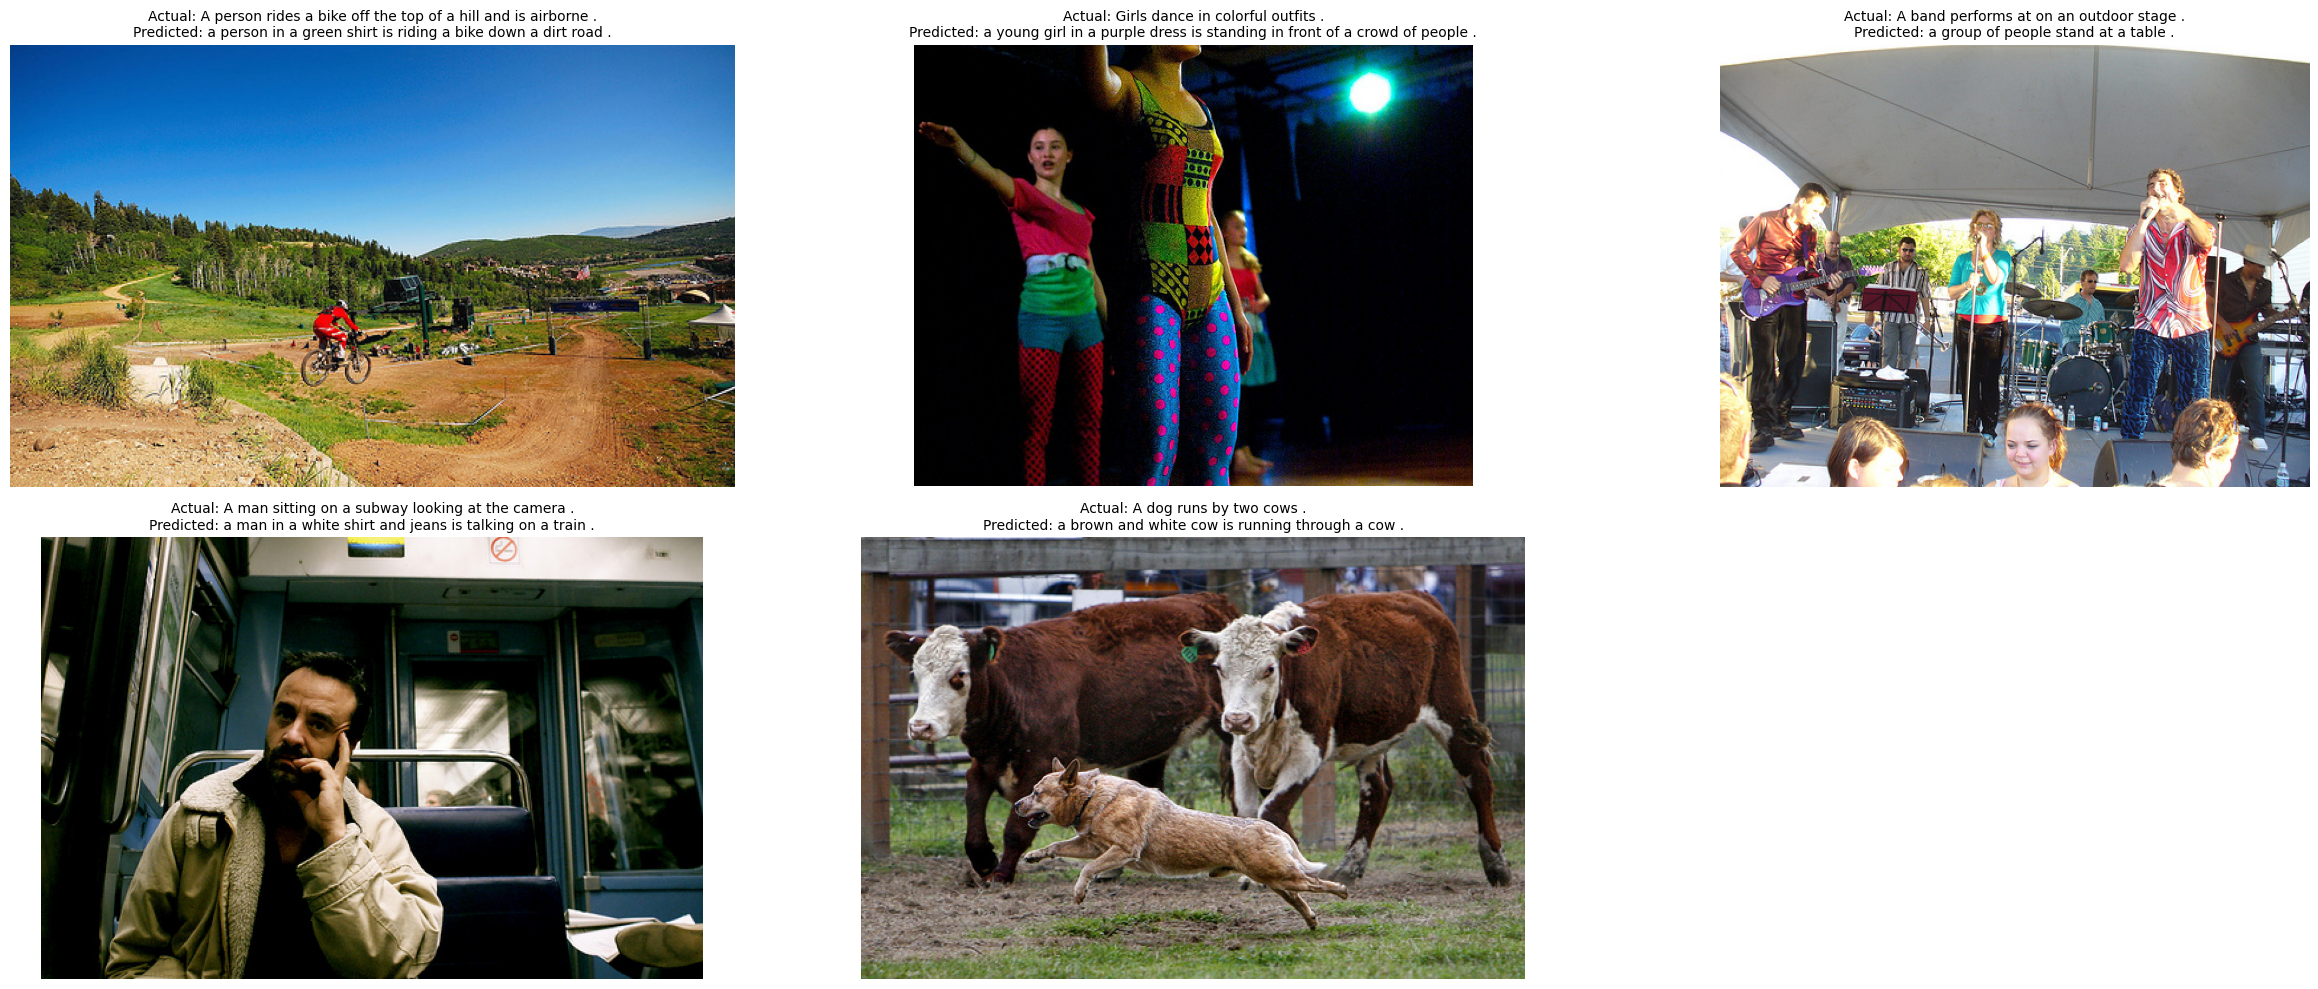

In [30]:
sample_df = test_df.sample(5)  # Randomly select 5 samples from the test set

plt.figure(figsize=(25, 10))  # Set figure size
for i, (idx, row) in enumerate(sample_df.iterrows()):
    # Get image path and actual caption
    img_path = os.path.join(image_dir, row['image'])
    actual_caption = row['caption']
    
    # Generate predicted caption
    predicted_caption = generate_caption(
        img_path, 
        encoder, 
        decoder, 
        vocab, 
        val_transform,  # Use validation transforms for consistency
        beam_width=3
    )
    
    # Plot the image with captions
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns grid
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f'Actual: {actual_caption}\nPredicted: {predicted_caption}', fontsize=10)
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()